# ADA - Final notebook

This notebook contains all the code which has been used to generate the plots and figures of our [datastory](https://antoineweber.github.io/ADA_Project_RobAda/).

As a summary, our goal was to investigate the potential difference between organic/bio products and regular ones, based on the [Open Food Facts](https://ch-en.openfoodfacts.org/data) dataset.

**TODO:** Add table of content. (Tkt Lucas avec mon extension jupyter j'ai juste a cliquer un bouton, pas besoin d'écrire 20 lignes a la main)

## Imports

In [1]:
import pickle
import pprint
import time
import sys
import os
import json
import copy
import folium
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import statsmodels.formula.api as sm

from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from math import pi

# We generate the interactive plots with Altair
import altair as alt

## Loading the dataset

In [2]:
# Make sure to download the dataset and place it in the data folder
OPEN_FOOD_FACTS_PATH = 'data/en.openfoodfacts.org.products.csv'
ENCODING = 'UTF-8'

chunksize = 100000
tfr = pd.read_csv(OPEN_FOOD_FACTS_PATH, encoding=ENCODING, sep='\t', chunksize=chunksize, iterator=True, low_memory=False)
food_facts_df = pd.concat(tfr, ignore_index=True)
food_facts_df.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,100g,...,NaN,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print("There are {} rows, hence products, in the dataset.".format(food_facts_df.shape[0]))
print("There are {} columns, hence fields, in the dataset.".format(food_facts_df.shape[1]))

There are 1067619 rows, hence products, in the dataset.
There are 177 columns, hence fields, in the dataset.


### Available fields <a class="anchor" id="availablefields"></a> 

The dataset description is available [here](https://static.openfoodfacts.org/data/data-fields.txt).

This dataset is provided with a text file describing the different fields. We present a brief overview of the main types of fields:

* field `code` containing the product's code. 
* field `creator` indicating who added the product to the dataset. 
* field `countries` showing where the product is selled. 
* fields that end with `_t` are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
* fields that end with `_datetime` are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
* fields that end with `_tags` are comma separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
* fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
* fields that end with `_100g` correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product
* fields that end with `_serving` correspond to the amount of a nutriment (in g, or kJ for energy) for 1 serving of the product

**TODO:** Add general cleaning part if it is still necessary

## Bio vs. regular products

A lot of products claim to be bio. Different terms are used depending on the location (organic, bio, ...), but overall they all refer to the same fact that the product was mostly produced in compliance with the standards of [organic farming](https://en.wikipedia.org/wiki/Organic_farming). In the common knowledge, people often claim that organic or bio products are healthier than non-organic products.

In the upcoming analysis, we will try to investigate whether this statement is quantitavely true or if sometimes companies take advantage of the "bio" acronym to gain market shares.

We will conduct this analysis by investigating different columns of interest: 

* We have access to two different nutritional scores. We will try to investigate whether differences can be observed with respect to this column, i.e if bio/organic products tend to obtain better nutritional scores than standard products.
    - In addition, some bio products may obtain bad nutritional scores. We will try to pinpoint why some bio products would still get such bad scores.
    
    
* As stated above, organic products should undergo as little tratment as possible, inducing a more natural product. This should directly be represented by a lower capacity in additives. Hence as a first step we will assess whether there is a different in additives between bio and normal products.

### Extracting organic/bio products

Some product contain words such as 'bio', 'biologic', 'organic' in their `product_name`, so this can be use to distinguish them from normal products. In addition, the dataset contains the columns `labels`, `labels_tags` and `labels_en`, which contain information about quality labels/certifications which also include bio products.

Thus, these columns can be used to split the dataset into 'bio' products and regular products. We will seach for keywords in these columns to determine if a product is bio:

In [4]:
bio_keywords = ['bio', 'organi'] # bio --> bio, biological, biologique, etc.; organi --> organic, organique

contains_bio_keywords = lambda x: any([(kw in str(x)) for kw in bio_keywords])

Let's add a new boolean column to the dataframe, to specify is the product is organic:

In [5]:
# Check for products matching the bio keywords in the 4 columns
bio_products = (food_facts_df['product_name'].apply(contains_bio_keywords)) \
             | (food_facts_df['labels'].apply(contains_bio_keywords)) \
             | (food_facts_df['labels_tags'].apply(contains_bio_keywords)) \
             | (food_facts_df['labels_en'].apply(contains_bio_keywords))

food_facts_df['bio'] = bio_products

print('There are {} bio products, and {} non-bio products.'.format(food_facts_df['bio'].sum(), 
                                                len(food_facts_df['bio']) - food_facts_df['bio'].sum()))
food_facts_df[food_facts_df['bio'] == True].head(5)

There are 75521 bio products, and 992098 non-bio products.


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,bio
20,0000000001427,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1550231727,2019-02-15T11:55:27Z,1550231732,2019-02-15T11:55:32Z,Pain de maïs bio,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
41,000000000429,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1567080029,2019-08-29T12:00:29Z,1567080749,2019-08-29T12:12:29Z,Jus de Pommes,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
66,000000001011,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1568142714,2019-09-10T19:11:54Z,1568143389,2019-09-10T19:23:09Z,Fromage blanc fermier de chèvre au lait entier,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
88,0000000014595,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1520321992,2018-03-06T07:39:52Z,1561463802,2019-06-25T11:56:42Z,Pâte de fruit fraise,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
97,0000000016087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1545997008,2018-12-28T11:36:48Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


We now have partition of our dataset into two sets: organic and regular products.

## Categorical analysis

**TODO: explain that this was a point of improvement from milestone 2**

For our analysis, we want to compare organic and regular products in terms of nutrional score, contained additives, nova groups and more. However, as shown in the previous section we have two highly unbalanced classes, as there are much fewer organic products. In addition to this, we don't know if the distribution of product categories is different between the regular and organic data. For instance, it could be possible that for organic products there are much more juices than other types of products.

In order to provide a more rigourous analysis, we will try to split the dataset into different categories, and then perform a comparative analysis in each category

### Determining the categories of products in the dataset

The open food facts dataset contains several columns representing the categories : **TODO: list the columns**. The column that is most present is `categories_en`. It is composed of a set of categories separated by commas. In addition, there are some metadata inside it to specify the language of the keywords, such `en:` and `fr:` for english and french respectively.

Our goal is to find out which categories are actually present in `categories_en`. Then we can find common categories to split the dataset based on keywords. For instance, if we wanted to find all the dairy products, we could look for the keywords `[milk, cheese, yoghurt]` in `categories_en`. 

We can also look for keywords related to the category in the `product_name` column. However, it would be more difficult to obtain a reliable splitting. Indeed, if we had a product named `goat milk`, it could be classified in the `meat` category since its name contains `goat`, whereas it's `categories_en` columns would not have `meat` in it. For this reason, we use only the `categories_en` column. **TODO: maybe check with both columns**

In [6]:
# Get the relevant column from the dataset
categories_df = food_facts_df[['categories_en']].dropna().copy()
categories_df.head(5)

,categories_en
3,"Groceries,Condiments,Sauces,Mustards"
4,fr:xsf
10,"Meals,Prepared vegetables,Grated carrots,Seaso..."
17,"Pies,Sweet pies,Coconut pies"
25,"Plant-based foods and beverages,Plant-based fo..."


Our goal is to identify the most common words describing the categories of products across the dataset. 

We use the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class to build a bag of words from `categories_en`.

We leverage the arguments of the class to transform all the words to lowercase, ignore stopwords and perform character normalization (remove accents, etc.). In addition, we discard the words that have less than **50** occurences.

In [7]:
def strip_accents(words):
    """ Remove accents in a list of words. """
    
    # If words is [], None or similar
    if not words:
        return words 
    
    # We use the CountVectorizer to actually remove accents
    vectorizer = CountVectorizer(lowercase=False, strip_accents='ascii')
    vectorizer.fit_transform(words)
    
    return vectorizer.get_feature_names()

# We use the stopwords from nltk
from nltk.corpus import stopwords

# We need french+english stopwords as there are both languages in the column
stop_words = stopwords.words('english')
stop_words.extend(strip_accents(stopwords.words('french')))

# These labels is present in the column to signify french/english categories
stop_words.append('fr')
stop_words.append('en')

# Remove dupplicates if any
stop_words = list(set(stop_words))

min_occurences = 50

vectorizer = CountVectorizer(stop_words=stop_words, lowercase=True, 
                             strip_accents='ascii', min_df=min_occurences)

bag = vectorizer.fit_transform(categories_df['categories_en'].values)
bag_features = vectorizer.get_feature_names()
print('There are {} different words in total.'.format(len(bag_features)))
print('Keywords:', bag_features[:10]) 

There are 1721 different words in total.
Keywords: ['10', '12', '18', '2000', '2012', '2013', 'ab', 'abbey', 'abondance', 'abricot']


Let's find out the most common words:

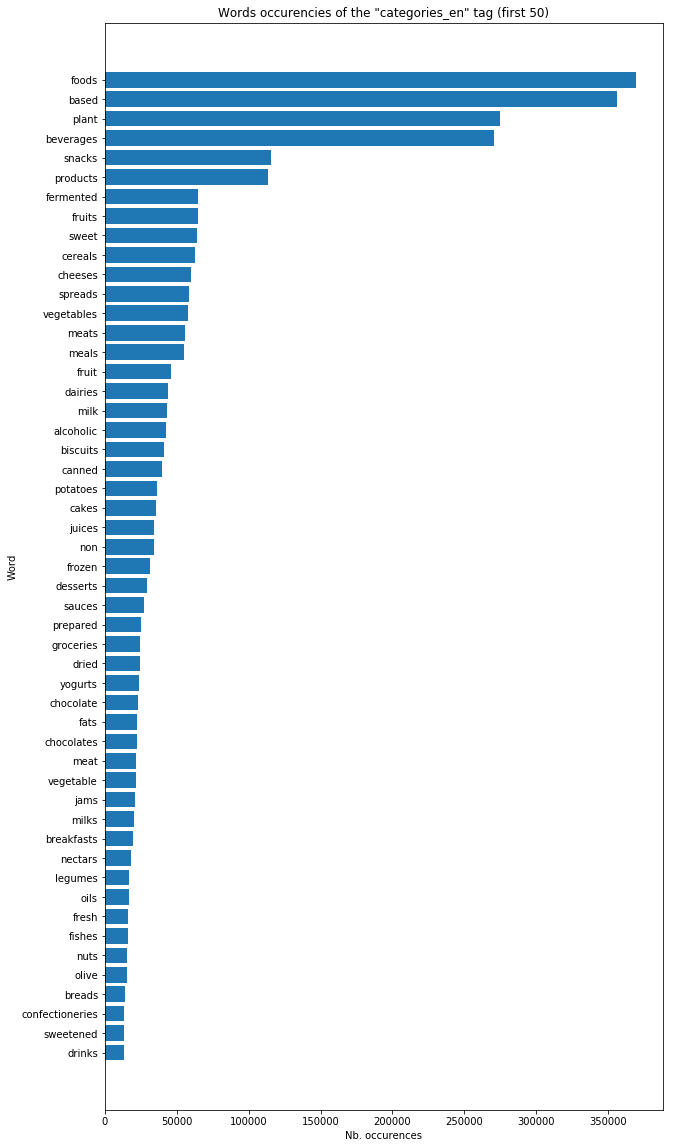

In [8]:
# Sum along the columns to get the total number of occurencies of each token
words_occurences = np.array(bag.sum(axis=0))[0]

# Build a dataframe with the words occurencies
words_occurencies_df = pd.DataFrame({'word':bag_features,'count':words_occurences}).sort_values(by=['count'],ascending=False)\
                            .reset_index().drop(columns='index')

# Plot the most common words
n = 50
plt.figure(figsize=(10,20))
plt.barh(words_occurencies_df.loc[0:n]['word'].values[::-1],
         words_occurencies_df.loc[0:n]['count'].values[::-1])
plt.title('Words occurencies of the "categories_en" tag (first {})'.format(n))
plt.ylabel('Word')
plt.xlabel('Nb. occurences')
plt.show()

There is a good list of words that can be used for categories, although some of them are too general, for instance the most common ones which are `foods` and `based`.

Let's clean the column `categories_en` using the same pre-processing and stop-words removal as before:

In [9]:
preprocessor = vectorizer.build_preprocessor()
tokenizer = vectorizer.build_tokenizer()

categories_df['categories_en'] = categories_df['categories_en'].apply(preprocessor).apply(tokenizer)\
                                    .apply(lambda words: ' '.join([w for w in words if w not in stop_words]))
categories_df.head(5)

,categories_en
3,groceries condiments sauces mustards
4,xsf
10,meals prepared vegetables grated carrots seaso...
17,pies sweet pies coconut pies
25,plant based foods beverages plant based foods ...


We can now define a function that can be used to obtain the product that belong to a specific category defined by keywords:

In [10]:
def find_products_from_category(raw_df, pre_processed_df, category_keywords):
    """ Obtain the products that fall in a given category.
    
    A product belong to a category if its column `categories_en` contain
    one of the category_keywords.
    
    Args:
        raw_df: raw Open Food Facts dataframe to be able to fetch all the products information
        pre_processed_df: datframe where the columns `categories_en` have been
                          cleaned of stopwords, case, accents, etc.
        category_keywords: List of keywords to find in `categories_en`. Note that since the
                           pre_processed_df is a clean string, there is no need to include
                           variations such as `cheese` and `cheeses`, a common step is enough.
        
    Return:
        The products that belong to the categories, with all the info from raw_df
    
    """
    
    products = pre_processed_df[pre_processed_df['categories_en'].apply(
                lambda x : any(kw in x for kw in category_keywords))]
    
    return raw_df.loc[products.index]

For instance let's obtain the dairy products:

In [11]:
dairy_kw = ['dairies','milk','cheese']
dairy_df = find_products_from_category(food_facts_df, categories_df, category_keywords=dairy_kw)
print('There are {} dairy products.'.format(dairy_df.shape[0]))
dairy_df.head(10)

There are 52320 dairy products.


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,bio
51,0000000005005,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1521663684,2018-03-21T20:21:24Z,1545934272,2018-12-27T18:11:12Z,Abondance,NaN,NaN,...,14.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
321,0000000491228,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1543690964,2018-12-01T19:02:44Z,1543692731,2018-12-01T19:32:11Z,Entremets Crème Brulée,NaN,20 g,...,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
766,0000405017511,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1551706268,2019-03-04T13:31:08Z,1552159083,2019-03-09T19:18:03Z,Chaource lait cru,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1008,0000939333330,http://world-en.openfoodfacts.org/product/0000...,emoups,1569696676,2019-09-28T18:51:16Z,1569697074,2019-09-28T18:57:54Z,creme fraiche,NaN,"213g, 7.5OZ",...,14.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1084,00011747,http://world-en.openfoodfacts.org/product/0001...,teolemon,1424634361,2015-02-22T19:46:01Z,1561464979,2019-06-25T12:16:19Z,Triple Belgian Chocolaté Chunk Cookies,NaN,225 g e,...,23.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1093,0001200001217,http://world-en.openfoodfacts.org/product/0001...,date-limite-app,1534008219,2018-08-11T17:23:39Z,1545929001,2018-12-27T16:43:21Z,comte,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1121,00013029,http://world-en.openfoodfacts.org/product/0001...,beniben,1494672859,2017-05-13T10:54:19Z,1494674596,2017-05-13T11:23:16Z,Cheddar,Cheddar en tranches,"7.788 kg (6 * 1,298 kg)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1226,0002000000707,http://world-en.openfoodfacts.org/product/0002...,kiliweb,1536492887,2018-09-09T11:34:47Z,1569853724,2019-09-30T14:28:44Z,Camenbert de Normandie,NaN,NaN,...,16.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1227,0002000000714,http://world-en.openfoodfacts.org/product/0002...,kiliweb,1518439760,2018-02-12T12:49:20Z,1552560002,2019-03-14T10:40:02Z,Yaourt nature brebis,NaN,NaN,...,-3.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1243,0002000001698,http://world-en.openfoodfacts.org/product/0002...,kiliweb,1549132328,2019-02-02T18:32:08Z,1552569293,2019-03-14T13:14:53Z,Yaourt au lait de brebis bio Nature,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


### Choice of categories

There are several possible choice of categories in which we can split the products. For instance, the products could be selected and grouped based on their type, following the food pyramid:

<img src="images/Food_pyramid.gif">

However, this splitting would yield highly unbalanced categories, and we would not produce granular categories.

Instead, we decided to choose a set of categories and sub-categories drawing inspiration from the [Ciqual dataset](https://www.data.gouv.fr/en/datasets/table-de-composition-nutritionnelle-des-aliments-ciqual/) that we investigated during milestone 2. The food products are separated in 3 levels of categories, and we produced the following categories based on it. As we have products in english as well as in french, we provide the french translation of the subcategory to search as well in this languages.

In [11]:
categories = \
{
    'meat, fish, egg':
    {
        'meat': 'viande',
        'fish': 'poisson',
        'egg': 'oeuf',
    },
    
    # TODO: check : Not enough data in openfoodfact from fresh products as there is mostly processed food
    'fruit, vegetable':
    {
        'fruit': 'fruit',
        'vegetable': 'legume',
        'legume': 'Legumineuse',
        'seed': 'graine',
    },
    
    'cereal': # Cereal-based products
    {
        'pasta': 'pate',
        'rice': 'riz',
        'flour': 'farine',
        'bread': 'pain',
        'biscuit': 'biscuit',
        #'cereals': 'cereales' # Breakfast
    },
    
    'drink':
    {
        'water': 'eau',
        'juice': 'jus',
        'soda': 'boisson gazeuse',
        'alcohol': 'alcool',
    },
    
    'dairy':
    {
        'milk': 'lait',
        'cheese': 'fromage',
        'yoghurt': 'yaourt',
        'cream': 'creme',
    },
    
    'cooking ingredient':
    {
        'salsa': 'sauce',
        'spice': 'epice',
        'salt': 'sel',
        'herb': 'herbe',
        'condiment': 'condiment',
    },
    
    'fat':
    {
        'oil': 'huile',
        'butter': 'beurre',
    },
    
    'sugary product':
    {
        'sugar': 'sucre',
        'jam': 'confiture',
        'candy': 'bonbon',
        'chocolate': 'chocolat',
        'ice cream': 'glace',
    },
}

We have quite a few categories, but we now need to find keywords associated to each of them. We could create this list manually but this can prove to be quite tedious and time-consuming. Instead we will harness the power of web-scraping to get such lists automatically.

### Web scraping the category keywords

Wikipedia has pages that list food by categories, but the formatting not homogenous and we would not go faster if we needed to implement a robust scrapping method.

Instead, what we can do is use the name of our categories and find their synonyms using [synonymy](http://www.synonymy.com/synonym.php?word=bob) for instance. For each keywords of categories, we can fetch a list of synonym that we cross-reference with the actual categories in our dataset (obtained previously with CountVectorizer). Finally, we manually filter out the words that are too generic or irrelevant.

We will use BeautifulSoup for web scraping the results.

In [12]:
import requests
from bs4 import BeautifulSoup

Let's define a function to get the webpage associated to the word of which we want to know the synonyms, and fetch the results. We chose this website because it is easy to scrap, and it has also a french version which uses the same HTML layout !

In [13]:
def get_synonyms(word, language='en'):
    """ Fetch the list of synonyms by scrapping the website http://www.synonymy.com, 
    or its French version http://www.synonymes.com (which is exactly the same).
    
    Args:
        word: Word for which to fetch the synonyms
        language: 'en' or 'fr'
        
    Return:
        A list of string which are the synonyms.
    
    """
    BASE_URL_EN = 'http://www.synonymy.com/synonym.php?word={word}'
    BASE_URL_FR = 'http://www.synonymes.com/synonyme.php?mot={word}'
    
    # Build url
    if language == 'en':
        url = BASE_URL_EN.format(word=word)
    elif language == 'fr':
        url = BASE_URL_FR.format(word=word)

    # Get web page for specified word
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    synonyms = []
    
    # The synonyms on this website are in 'div' with class 'defbox'
    for defbox in soup.find_all('div', {'class': 'defbox'}):
        synonyms_links = defbox.find_all('a')
        synonyms.extend([s.text for s in synonyms_links])
        
    # Remove dupplicates
    synonyms = list(set(synonyms))
    
    # Remove empty strings ('')
    synonyms = [s for s in synonyms if s]
    
    # Remove accents
    synonyms = strip_accents(synonyms)
    
    return synonyms

Let's see how it works:

In [16]:
print('english:', get_synonyms('fruit', 'en'))
print('french:', get_synonyms('fruit', 'fr'))

english: ['aftermath', 'capsule', 'effect', 'mature', 'nut', 'outcome', 'pay', 'pod', 'product', 'seed']
french: ['agrume', 'avantage', 'baie', 'benefice', 'conclusion', 'consequence', 'de', 'drupe', 'effet', 'fruits', 'germe', 'graine', 'mer', 'moisson', 'nature', 'pepins', 'produit', 'profit', 'rapport', 'recompense', 'resultat', 'rouges', 'secs']


Now, we have a way to find keywords related to our categories. For each subcategory, we can fetch the synonyms in english and in french. We keep only the synonyms that are present in the list of keywords of categories that we had extracted from the Open Food Facts dataset:

In [17]:
# Build the list of keywords for the sub categories
category_keywords = copy.deepcopy(categories)

for category in categories:
    print(category)
    for english, french in categories[category].items():
        
        # Fetch synonyms
        synonyms = get_synonyms(english, 'en')
        synonyms.extend(get_synonyms(french, 'fr'))
        
        # Remove dupplicates
        synonyms = list(set(synonyms))
        
        # Keep only categories in Open Food Facts
        synonyms = [s for s in synonyms if s in words_occurencies_df.word.values]
        
        # Always include name of sub category
        if french != english:
            synonyms.insert(0, french)
        synonyms.insert(0, english)
        
        category_keywords[category][english] = synonyms
        
        print('\t', english)
        print('\t\t', category_keywords[category][english])

meat, fish, egg
	 meat
		 ['meat', 'viande', 'beef', 'chair', 'veau', 'lean', 'turkey', 'meal', 'volaille', 'porc', 'lamb', 'agneau', 'food', 'short']
	 fish
		 ['fish', 'poisson', 'peche', 'fish', 'seafood', 'poisson']
	 egg
		 ['egg', 'oeuf']
fruit, vegetable
	 fruit
		 ['fruit', 'nature', 'seed', 'rouges', 'produit', 'secs', 'nut', 'mer', 'fruits']
	 vegetable
		 ['vegetable', 'legume', 'plant', 'organic']
	 legume
		 ['legume', 'Legumineuse']
	 seed
		 ['seed', 'graine', 'corn', 'berry', 'plant', 'grain', 'nut']
cereal
	 pasta
		 ['pasta', 'pate', 'paste', 'vent', 'gateau', 'terrine', 'bloc', 'foie', 'creme']
	 rice
		 ['rice', 'riz', 'eau', 'riz', 'vie']
	 flour
		 ['flour', 'farine', 'farine']
	 bread
		 ['bread', 'pain', 'pain', 'petit', 'lait', 'meals', 'meal', 'croute', 'grain', 'food', 'campagne']
	 biscuit
		 ['biscuit']
drink
	 water
		 ['water', 'eau', 'boisson', 'ice', 'liquid', 'jus']
	 juice
		 ['juice', 'jus', 'boisson', 'fruit', 'vie', 'drink', 'liqueur', 'eau', 'jus'

As you can see the keywords are quite good, but there are still a few irrelevant keywords (for instance: `jam` is associated with the words `fix` and `box` which are not synonyms in the case of the food.

There are few keywords so that we can manually edit the results and remove the irrelevant or too generic keywords; we can also add some if we feel like there are some missing.

In [18]:
# Save as json for manual editing
with open('data/category_keywords.json', 'w') as outfile:
    json.dump(category_keywords, outfile, indent=2)

Here is the final version after manual editing:

In [108]:
with open('data/category_keywords_edited.json', 'r') as file:
    category_keywords = json.load(file)

pprint.pprint(category_keywords)

{'cereal': {'biscuit': ['biscuit'],
            'bread': ['bread', 'pain', 'croute'],
            'flour': ['flour', 'farine'],
            'pasta': ['pasta', 'pate'],
            'rice': ['rice', 'riz']},
 'cooking ingredient': {'condiment': ['condiment',
                                      'seasoning',
                                      'flavouring',
                                      'assaisonnement'],
                        'herb': ['herb', 'herbe'],
                        'salsa': ['salsa', 'sauce'],
                        'salt': ['salt', 'sel', 'sodium'],
                        'spice': ['spice',
                                  'epice',
                                  'seasoning',
                                  'assaisonnement',
                                  'zest',
                                  'pepper',
                                  'piment']},
 'dairy': {'cheese': ['cheese', 'fromage'],
           'cream': ['cream', 'creme'],
           'milk': 

With this final list of keywords, we can easily fetch the products that belong to a given sub-category.

### Categorical dataframes

We can now split the data in categories. Please note that the **categories may overlap !** Indeed, we merely search by keywords and do not impose any constraints on the obtained set of products. This is fine as long as we keep this fact in mind.

Let's fill in a dictionary that will contain a dataframe for each subcategory. For the parent categories, we would simply need to merge the children subcategory dataframes.

In [109]:
sub_categories_df_dict = copy.deepcopy(categories)

parent_categories_df_dict = {}

for category in sub_categories_df_dict:
    print(category)
    
    for subcategory in sub_categories_df_dict[category]:
        
        # Get keywords associated to the subcategory
        subcategory_kw = category_keywords[category][subcategory]

        # Get dataframe of products in the subcategory
        sub_categories_df_dict[category][subcategory] = \
                                find_products_from_category(food_facts_df, categories_df, 
                                                            category_keywords=subcategory_kw)
        
        print('\t', subcategory)
        print('\t\t number of products:', sub_categories_df_dict[category][subcategory].shape[0])
    
    parent_categories_df_dict[category] = pd.concat([df for df in sub_categories_df_dict[category].values()])
    print('\t total products:', parent_categories_df_dict[category].shape[0])

meat, fish, egg
	 meat
		 number of products: 65934
	 fish
		 number of products: 18340
	 egg
		 number of products: 6627
	 total products: 90901
fruit, vegetable
	 fruit
		 number of products: 70979
	 vegetable
		 number of products: 122225
	 legume
		 number of products: 8751
	 seed
		 number of products: 30983
	 total products: 232938
cereal
	 pasta
		 number of products: 14372
	 rice
		 number of products: 8252
	 flour
		 number of products: 1876
	 bread
		 number of products: 13801
	 biscuit
		 number of products: 23678
	 total products: 61979
drink
	 water
		 number of products: 7290
	 juice
		 number of products: 9515
	 soda
		 number of products: 3697
	 alcohol
		 number of products: 42992
	 total products: 63494
dairy
	 milk
		 number of products: 45886
	 cheese
		 number of products: 23014
	 yoghurt
		 number of products: 1173
	 cream
		 number of products: 11257
	 total products: 81330
cooking ingredient
	 salsa
		 number of products: 18987
	 spice
		 number of products: 428

**TODO: remove haha**

**My beloved team members you can now use the dataframe of each sub categories as follows:**

In [21]:
# For a subcategory
sub_categories_df_dict['sugary product']['sugar'].head(5)

# For a parent category
parent_categories_df_dict['sugary product'].head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,bio
400,0000010206515,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1511122551,2017-11-19T20:15:51Z,1511124271,2017-11-19T20:44:31Z,Pâte à Sucre,Pâte à Sucre - Fondant,250 g,...,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
414,0000010216477,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1530396566,2018-06-30T22:09:26Z,1561464028,2019-06-25T12:00:28Z,Pate a sucre,NaN,NaN,...,17.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
415,0000010216491,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1524386529,2018-04-22T08:42:09Z,1542756116,2018-11-20T23:21:56Z,Pâte à sucre,NaN,NaN,...,17.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
512,0000030053014,http://world-en.openfoodfacts.org/product/0000...,date-limite-app,1430153513,2015-04-27T16:51:53Z,1543066400,2018-11-24T13:33:20Z,Pastille Vichy,"Bonbon Vichy avec édulcorants, parfum menthe",19 g e,...,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
577,0000069029790,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1524583040,2018-04-24T15:17:20Z,1561464325,2019-06-25T12:05:25Z,Gaufres de Bruxelles,NaN,NaN,...,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


## Plot generation

**TEAM:** Until we have a good altair plot, you can use the following snippet to plot by categories or sub categories:

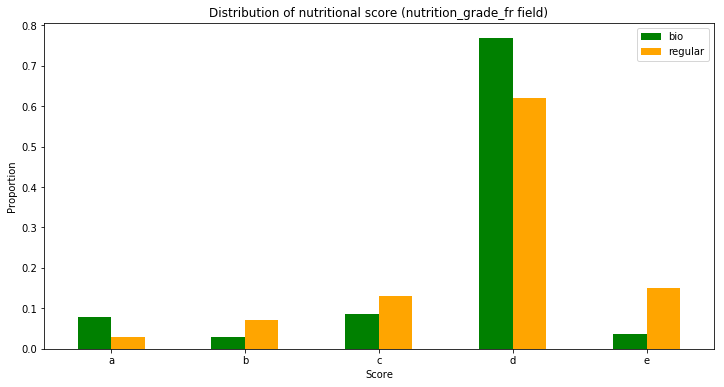

In [229]:
score_field = 'nutrition_grade_fr' # or 'nova_group' or 'nutrition-score-uk_100g'

category = 'sugary product'
subcategory = 'sugar'

df = sub_categories_df_dict[category][subcategory]

# For a parent category
#df = parent_categories_df_dict[category]

scores_df = pd.DataFrame([df[df['bio'] == True][score_field].value_counts(normalize=True).sort_index().rename('bio'),
             df[df['bio'] == False][score_field].value_counts(normalize=True).sort_index().rename('regular')])

scores_df = scores_df.transpose()

scores_df.plot(kind='bar', color=['green', 'orange'], rot=0, figsize=(12, 6))

plt.title('Distribution of nutritional score (nutrition_grade_fr field)')
plt.xlabel('Score')
plt.ylabel('Proportion')

plt.show()

### Nutritional score for each category

We want to plot the nutritional score for bio vs. regular products. The score distribution can be filtered for a category of products or a subcategory of products.

We could leverage the Altair API to use directly the whole dataframe as in the following commented cell, but then every product would be encoded in the final json files for each plot, which is intractable.

In [22]:
"""score_field = 'nutrition_grade_fr'

bar_plot = alt.Chart(food_facts_df).mark_bar().encode(
    x= alt.X(score_field, bin=True),
    y='Count()'
    color='bio'
)"""

"score_field = 'nutrition_grade_fr'\n\nbar_plot = alt.Chart(food_facts_df).mark_bar().encode(\n    x= alt.X(score_field, bin=True),\n    y='Count()'\n    color='bio'\n)"

Instead, we generate much smaller dataframe with the final data we want to plot and render them using Altair.

In [37]:
score_field = 'nutrition_grade_fr'

scores_bio_df = pd.DataFrame([food_facts_df[food_facts_df['bio'] == True][score_field] \
                                                .value_counts(normalize=True).sort_index().rename('proportion')])

scores_bio_df = scores_bio_df.transpose()
scores_bio_df['type'] = 'bio'

scores_regular_df = pd.DataFrame([food_facts_df[food_facts_df['bio'] == False][score_field] \
                                                .value_counts(normalize=True).sort_index().rename('proportion')])

scores_regular_df = scores_regular_df.transpose()
scores_regular_df['type'] = 'regular'

scores_df = pd.concat([scores_bio_df, scores_regular_df])
scores_df.reset_index(level=0, inplace=True)
scores_df.rename(columns={'index': 'score'}, inplace=True)

scores_df

,score,proportion,type
0,a,0.220034,bio
1,b,0.165489,bio
2,c,0.224078,bio
3,d,0.243772,bio
4,e,0.146628,bio
5,a,0.137953,regular
6,b,0.133492,regular
7,c,0.214478,regular
8,d,0.311105,regular
9,e,0.202971,regular


In [223]:
hover = alt.selection_single(on='mouseover', nearest=False, empty='none', encodings=['y'])

bar_plot = alt.Chart(scores_df).mark_bar().encode(
    column = alt.Column('score:N', title='Nutritional score'),
    x = alt.X('type:O', title=None, axis=None),
    y = alt.Y('proportion:Q', title='Proportion of products'),
    color = alt.Color('type:N', title='Type of product'),
    strokeOpacity = alt.condition(hover, alt.value(1), alt.value(0)),
    tooltip = alt.Tooltip(['proportion'], format='.1%')) \
        .configure_bar(cornerRadius=3, stroke='blue', strokeWidth=3) \
        .configure_axis(grid=False) \
        .configure_view(strokeOpacity=0) \
        .add_selection(hover)

In [224]:
bar_plot.save('plots/bar.html')

### Sunburst categories

In [33]:
def categories_to_json_tree(categories, json_path):
    
    tree = []
    
    element_id = 1
    root_id = element_id
    
    tree.append({
            'id': element_id,
            'name': 'all products',
        })
    
    for category in categories:
        element_id += 1
        parent_id = element_id
        
        tree.append({
            'id': element_id,
            'name': category,
            'parent': root_id
        })
        
        for subcategory in categories[category]:
            element_id += 1
            
            tree.append({
                'id': element_id,
                'name': subcategory,
                'parent': parent_id,
                'size': 20
            })
            
    with open(json_path, 'w') as outfile:
        json.dump(tree, outfile)

In [34]:
categories_to_json_tree(categories, 'data/categories_tree.json')

### Select categories plot

In [16]:
def compute_category_summary(field, cat='all products', subcat=None):
    
    # Get the correct data collection
    if cat == 'all products':
        df = food_facts_df
    elif subcat is None and cat in parent_categories_df_dict:
        df = parent_categories_df_dict[cat]
    elif subcat and cat in parent_categories_df_dict and subcat in sub_categories_df_dict[cat]:
        df = sub_categories_df_dict[cat][subcat]
    else:
        print('Unknown category')
        return
    
    
    summary_bio_df = pd.DataFrame([df[df['bio'] == True][field] \
                                        .value_counts(normalize=True).sort_index().rename('proportion')])

    summary_bio_df = summary_bio_df.transpose()
    summary_bio_df['type'] = 'bio'

    summary_regular_df = pd.DataFrame([df[df['bio'] == False][field] \
                                        .value_counts(normalize=True).sort_index().rename('proportion')])

    summary_regular_df = summary_regular_df.transpose()
    summary_regular_df['type'] = 'regular'

    summary_df = pd.concat([summary_bio_df, summary_regular_df])
    summary_df.reset_index(level=0, inplace=True)
    summary_df.rename(columns={'index': 'score'}, inplace=True)
    
    # Add single category for filtering latter in the plots
    if cat == 'all products':
        summary_df['category'] = 'all products'
    elif subcat is None and cat in parent_categories_df_dict:
        summary_df['category'] = cat
    elif subcat and cat in parent_categories_df_dict and subcat in sub_categories_df_dict[cat]:
        summary_df['category'] = subcat

    return summary_df

def compute_all_categories_summary(field):
    
    summary_df = compute_category_summary(field, cat='all products', subcat=None)
    
    for category in sub_categories_df_dict:
        
        summary_df = pd.concat([summary_df, compute_category_summary(field, cat=category, subcat=None)])
    
        for subcategory in sub_categories_df_dict[category]:
            
            summary_df = pd.concat([summary_df, 
                                    compute_category_summary(field, cat=category, subcat=subcategory)])
                                   
    summary_df.reset_index(level=0, drop = True, inplace=True)
    
    return summary_df

In [17]:
scores_df = compute_all_categories_summary(field='nutrition_grade_fr')
scores_df

,score,proportion,type,category
0,a,0.220034,bio,all products
1,b,0.165489,bio,all products
2,c,0.224078,bio,all products
3,d,0.243772,bio,all products
4,e,0.146628,bio,all products
...,...,...,...,...
404,a,0.007123,regular,ice cream
405,b,0.022289,regular,ice cream
406,c,0.307215,regular,ice cream
407,d,0.544118,regular,ice cream


In [18]:
# Category dropdown filter
genre_dropdown = alt.binding_select(options=list(scores_df['category'].value_counts().index), name="Product category")
genre_select = alt.selection_single(fields=['category'], bind=genre_dropdown, name="Product category")

bar_plot = alt.Chart(scores_df).mark_bar().encode(
    column = alt.Column('score:N', title='Nutritional score'),
    x = alt.X('type:O', title=None, axis=None),
    y = alt.Y('proportion:Q', title='Proportion of products'),
    color = alt.Color('type:N', title='Type of product'),
    tooltip = alt.Tooltip(['proportion'], format='.1%')) \
        .configure_bar(cornerRadius=3) \
        .configure_axis(grid=False) \
        .configure_view(strokeOpacity=0) \
        .add_selection(genre_select).transform_filter(genre_select)

# To visualize the standalone plot 
bar_plot.save('plots/cat.html')

In [19]:
# Save it to json for the data story
bar_plot.save('plots/nutritional_score.json')

### Wordcloud for the categories

To install the latest version of the library:

```bash
git clone https://github.com/amueller/word_cloud.git
cd word_cloud
pip install .
```

In [48]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [105]:
def create_wordcloud(words, image, save_path=None):
    
    # Wordcloud expects the transparency color to be white with alpha=0
    image[(image == (0, 0, 0, 0)).all(axis=2)] = (255, 255, 255, 0)
    
    result_wordcloud = WordCloud(stopwords=stop_words, mask=image, background_color='white', mode="RGBA", 
                                 prefer_horizontal=0.8, max_words=1000).generate(words)

    # create coloring from image
    image_colors = ImageColorGenerator(image)
    plt.figure(figsize=[7,7])
    plt.imshow(result_wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")

    if save_path:
        result_wordcloud.to_file(save_path)

    plt.show()

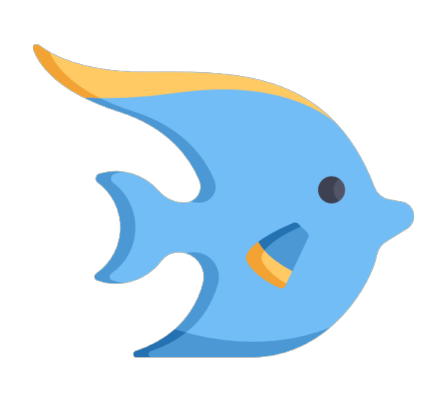

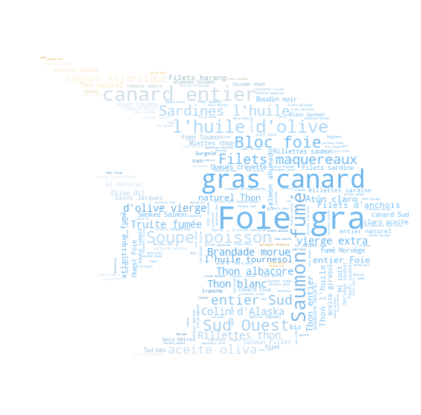

In [110]:
bread = np.array(Image.open("images/fish.png"))

plt.figure(figsize=[7,7])
plt.imshow(bread, interpolation="bilinear")
plt.axis("off")
plt.show()

df = sub_categories_df_dict['meat, fish, egg']['fish']

words = ' '.join(df['product_name'].astype(str).values)

create_wordcloud(words, image=bread, save_path='images/fish_wc.png')